In [1]:
import numpy as np
import gym
from gym import wrappers
import time
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
from matplotlib import animation
from IPython.display import display
from collections import deque

In [2]:
# In how many slices discretize the continuous space, the bigger, the smoother. but it increases a lot the time to converge!
# Try and check to see how they work!
numStates_pos = 10
numStates_speed = 20
numStates = np.array([numStates_pos, numStates_speed])

# The environment low, high and interval mapped per state
env_low = None
env_high = None
env_dx = None

# Number of episodes
numEpisodes = 50000
maxStepsPerEpisode = 200 # Number of max actions taken per episode. If in 200 steps it's not done, the environment takes it as fail.

# Tweaking params
initial_lr = 1.0 # Initial Learning Rate
lr_decay = 0.999
min_lr = 0.001 # Minimum Learning Rate
gamma = 1.0 # Discount factor
epsilon_start = 1.0 # Allow the model to do a lot of trial and error on the beggining
epsilon_decay = 0.999 # Decay per episode.
epsilon_end = 0.01 # The end point / min of the epsilon

In [3]:
# get epsilon by Episode
def get_epsilon(n_episode):
    epsilon = max(epsilon_start * (epsilon_decay ** n_episode), epsilon_end)
    return (epsilon)

In [4]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(HTML(anim.to_jshtml()))

In [5]:
def obs_to_state(env, obs):
    """ Maps an observation to state """
    if (type(obs) is tuple):
        obs = obs[0]

    position = int((obs[0] - env_low[0])/env_dx[0]) # obs[0] = [-1.2, 0.6]
    speed = int((obs[1] - env_low[1])/env_dx[1]) # obs[1] = [-0.07, 0.07]
    return position, speed

In [6]:
def run_episode(env, policy=None, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    frames = []
    for _ in range(maxStepsPerEpisode):
        if render:
            frames.append(env.render())
        if policy is None:
            action = env.action_space.sample()
        else:
            pos, speed = obs_to_state(env, obs)
            action = policy[pos][speed]
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
        step_idx += 1
        if done:
            break

    if render:
        #env.render()
        display_frames_as_gif(frames)
        env.close()
    return total_reward

In [7]:
def train_q_learning(env):
    print('Start Q-Learning training:')
    display_freq = min(numEpisodes // 10, 1000)

    # Initialize Q-Table
    q_table = np.random.uniform(-1, 1, (numStates[0], numStates[1], 3))  # [number_of_positions x number_of_speeds x number_of_actionst]
    last100_moving_total = 0
    last100_rewards = deque()
    SOLVED = False
    last_total_rewards = [] # For stat purposes, accumultates some episode rewards
    for i in range(numEpisodes):
        epsilon_to_use = get_epsilon(i)
        obs = env.reset()
        total_reward = 0

        ## Learning rate is decreased at each step. Just another version of what you've seen in the previous labs
        lr = max(min_lr, initial_lr * (lr_decay ** i))

        for j in range(maxStepsPerEpisode):
            pos, speed = obs_to_state(env, obs)  # Get action,state to pick from Q-Table

            if np.random.uniform(0, 1) < epsilon_to_use:  # Randomize sometimes
                action = np.random.choice(env.action_space.n)
            else:
                # Q-Table picking process
                logits = q_table[pos][speed]  # Actions for
                logits_exp = np.exp(logits)
                probs = logits_exp / np.sum(logits_exp)
                action = np.random.choice(env.action_space.n, p=probs)

            obs, reward, done, _, _ = env.step(action)
            total_reward += reward

            # Update Q-Table
            pos_next, speed_next = obs_to_state(env, obs)
            target = reward + gamma * np.max(q_table[pos_next][speed_next])
            q_table[pos][speed][action] = q_table[pos][speed][action] + lr * (target - q_table[pos][speed][action])

            if done:
                break

        last100_rewards.append(total_reward)
        last100_moving_total += total_reward
        while len(last100_rewards) > 100:
            removedItem = last100_rewards.popleft()
            last100_moving_total -= removedItem
        last100_moving_avg = last100_moving_total / len(last100_rewards)
        if len(last100_rewards) >= 100 and last100_moving_avg >= -180:
            print(f"We solved the game at episode {i} !")
            SOLVED = True
            break

        if i % display_freq == 0:  # Write out partial results
            print(f'At episode: {i+1} - Reward mean from last 100 episodes: {last100_moving_avg}. - LR:{lr:0.4f} - eps:{epsilon_to_use:0.4f}')
            last_total_rewards.clear()

    print('Training finished!')
    solution_policy = np.argmax(q_table, axis=2)
    solution_policy_scores = [run_episode(env, solution_policy, False) for _ in range(1000)]
    print("Average score of solution on a dry run = ", np.mean(solution_policy_scores))

    return solution_policy

Start Q-Learning training:
At episode: 1 - Reward mean from last 100 episodes: -200.0. - LR:1.0000 - eps:1.0000


c:\Users\anama\anaconda3\envs\rl_env\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


At episode: 1001 - Reward mean from last 100 episodes: -200.0. - LR:0.3677 - eps:0.3677
At episode: 2001 - Reward mean from last 100 episodes: -198.3. - LR:0.1352 - eps:0.1352
At episode: 3001 - Reward mean from last 100 episodes: -198.61. - LR:0.0497 - eps:0.0497
We solved the game at episode 3749 !
Training finished!
Average score of solution on a dry run =  -167.531


-181.0

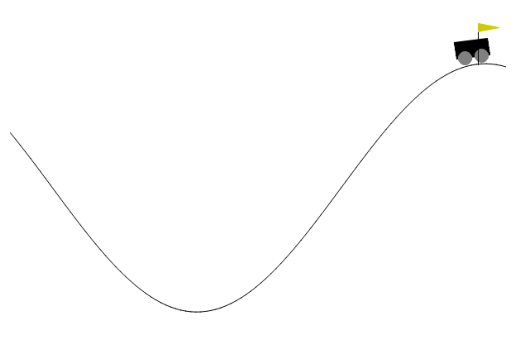

In [8]:
env_name = 'MountainCar-v0'
env = gym.make(env_name, render_mode='rgb_array')

# Read the env things
env_low = env.observation_space.low
env_high = env.observation_space.high
env_dx = (env_high - env_low) / numStates

# Train a policy. TODO: save it
sol_policy = train_q_learning(env)

# Play simulation with the learned policy
run_episode(env, sol_policy, True)